# Introduction
  In Reddit, there is a subreddit called WallStreetBets (r/wallstreetbets) where participants discuss stock and option trading. This subreddit went viral because it caused a significant fluctuation in the stock prices of GameStop in January 2021.
  
We obtained the dataset around that time from [Kaggle](https://www.kaggle.com/datasets/gpreda/reddit-wallstreetsbets-posts) to analysis the relationship between the post and stock price and also perform sentiment analysis.

In addtion, we obtain the dataset by ourselves with [Praw](https://github.com/praw-dev/praw) package in Python on r/wallstreetbets. The dataset included the recent post (Novembere 2023) and some hottest post in 2023.

# The required packages

In [1]:
import pandas as pd
import re
import os
import openai
from time import sleep
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import yfinance as yf
from collections import Counter
## for plot
from datetime import datetime, timedelta, timezone
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import praw

[nltk_data] Downloading package stopwords to /Users/thl/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Function in Use

The `get_post_freq` function returns a Dataframe that summary the post frequency of given DataFrame into the `timestamp` and `frequency` columns. The frequency shows the number of posts in [`timestamp`, `timestamp` + `interval`). 

In [2]:
def get_post_freq(timestamps, interval: timedelta, start_time: datetime = None, end_time: datetime = None) -> pd.DataFrame:
    datetime_list = [datetime.strptime(time, '%Y-%m-%d %H:%M:%S') for time in sorted(timestamps)] # convert string to datetime
    if start_time == None:
        start_time = datetime_list[0]
    if end_time == None:
        end_time = datetime_list[-1] + timedelta(seconds=1)
        
    datetime_list = [elem for elem in datetime_list if elem >= start_time and elem < end_time] # choose timestamps in the range from start_time to end_time
    datetime_list = [(elem - start_time) // interval for elem in datetime_list] # assign each timestamps to each interval
    datetime_list = [start_time + interval * elem for elem in datetime_list] # restore the real timestamps of each interval
    freq_list = list(Counter(datetime_list).items()) # aggregate timestamps into each interval

    if freq_list[-1][0] < end_time - interval: # add end bound
        freq_list.append((end_time - interval, 0))
    if freq_list[0][0] > start_time: # add start bound
        freq_list.insert(0, (start_time, 0))
    
    for i in range(len(freq_list)-2, -1, -1): # add 0s into the interval between two real records
        if freq_list[i + 1][0] - freq_list[i][0] > 2 * interval:
            freq_list.insert(i + 1, (freq_list[i + 1][0] - interval, 0))
            freq_list.insert(i + 1, (freq_list[i][0] + interval, 0))
        elif freq_list[i + 1][0] - freq_list[i][0] == 2 * interval:
            freq_list.insert(i + 1, (freq_list[i][0] + interval, 0))
    
    freq_df = pd.DataFrame(freq_list, columns=["timestamp", "frequency"])
    return freq_df

In [3]:
def plot_post_freq(df, interval = 1):
    interval = timedelta(days=interval)
    freq_df = get_post_freq(df["timestamp"], interval)
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=freq_df["timestamp"],
        y=freq_df["frequency"],
        xperiod=interval.total_seconds()*1000
    ))
    fig.update_layout(
        title_text=f"Post frequency",
        xaxis_title=f"timestamp (day)",
        yaxis_title="the number of post",
        # width=1000,
        # height=500,
    )
    fig.show()

# Prepare Dataset

## Dataset from Kaggle
Just download it from [Kaggle](https://www.kaggle.com/datasets/gpreda/reddit-wallstreetsbets-posts).

In [4]:
df_kaggle = pd.read_csv("./dataset/reddit_wsb.csv")
df_kaggle.shape

(53187, 8)

In [6]:
df_kaggle.sort_values(by="created").loc[0]

title        It's not about the money, it's about sending a...
score                                                       55
id                                                      l6ulcx
url                            https://v.redd.it/6j75regs72e61
comms_num                                                    6
created                                           1611862661.0
body                                                       NaN
timestamp                                  2021-01-28 21:37:41
Name: 0, dtype: object

In [7]:
df_kaggle.sort_values(by="created").loc[53186]

title        Fraternal Association of Gambling Gentlemen an...
score                                                       40
id                                                      owaqd6
url          https://www.reddit.com/r/wallstreetbets/commen...
comms_num                                                  810
created                                           1627894814.0
body         This is an old Yacht Club thread. Click /u/Vis...
timestamp                                  2021-08-02 12:00:14
Name: 53186, dtype: object

There are total 53187 posts in the dataset.

## Descriptive Analysis

In [37]:
df_kaggle.columns

Index(['title', 'score', 'id', 'url', 'comms_num', 'created', 'body',
       'timestamp'],
      dtype='object')

In [42]:
plot_post_freq(df_kaggle)

NameError: name 'plot_post_freq' is not defined

## Recent Dataset around November 2023

Use Praw package to obtain the data from Reddit API.

In [50]:
# The same columns as the kaggle dataset
df_2023 = pd.DataFrame(columns = ['title', 'score', 'id', 'url', 'comms_num', 'created', 'body', 'timestamp'])

In [55]:
# User's credential
reddit = praw.Reddit(
    client_id="VjQhhXD0WiNzaBsUBcOXsQ",
    client_secret="ZIwQQo6_2mJ16woXKFPiE3-ArYOxug",
    user_agent="Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7)",
)

# The target subreddit is "r/wallstreetbets"
subreddit = reddit.subreddit("wallstreetbets")

# Reddit limits it to 1000 so their servers don't die.
limit = 1000
for g in [subreddit.new(limit=limit), subreddit.top(limit=limit), subreddit.hot(limit=limit), subreddit.rising(limit=limit)]:
    for submission in g:
        data = {
            "title": submission.title,
            "score": submission.score,
            "id": submission.id,
            "url": submission.url,
            "comms_num": submission.num_comments,
            "created": submission.created_utc,
            "body": submission.selftext,
            "timestamp": datetime.fromtimestamp(submission.created_utc, timezone.utc).strftime('%Y-%m-%d %H:%M:%S')
        }
        df_2023.loc[len(df_2023)] = data

In [58]:
# Drop duplicated data
df_2023 = df_2023.drop_duplicates(["id"], ignore_index = True)

# Only included the data in year 2023
df_2023 = df_2023[df_2023["created"] >= datetime.timestamp(datetime(2023, 1, 1, tzinfo=timezone.utc))].reset_index(drop = True)
df_2023 = df_2023.sort_values(["created"], ignore_index = True)

It might take a little time to grab the data. We have already run the above code beforehand and store the dataset in `./dataset/reddit_wsb_2023.csv`. Just load it to save your time.

In [301]:
df_2023 = pd.read_csv("./dataset/reddit_wsb_2023.csv")
df_2023

,title,score,id,url,comms_num,created,body,timestamp
0,Tesla design is very human,50441,102zjj6,https://v.redd.it/29ls2ssf00aa1,838,1.672826e+09,NaN,2023-01-04 09:50:17
1,To The Moon,34788,103v2iq,https://i.redd.it/2co7wgrw47aa1.jpg,2228,1.672912e+09,NaN,2023-01-05 09:47:34
2,Inverse Cramer,39755,1094bz8,https://i.redd.it/y0mmmo76ggba1.jpg,746,1.673443e+09,NaN,2023-01-11 13:10:50
3,Man loses a 1.4 million dollar bet to win… 11k...,39887,10cc0us,https://i.redd.it/y1io68w7t6ca1.jpg,2924,1.673762e+09,NaN,2023-01-15 05:50:16
4,Google is doing layoffs,53468,10jkhm1,https://v.redd.it/zvsa581ncuda1,5580,1.674501e+09,NaN,2023-01-23 19:04:40
...,...,...,...,...,...,...,...,...
914,VIX hit 52 week low today. We all know what th...,2,18c9wwc,https://www.reddit.com/r/wallstreetbets/commen...,7,1.701886e+09,Buy calls 🤦🏼‍♂️ (NFA)\n\nHonestly I don’t know...,2023-12-06 18:01:23
915,Bulls deep fisted today friends,4,18ca60h,https://i.redd.it/yfnijdxstp4c1.jpeg,3,1.701886e+09,NaN,2023-12-06 18:11:59
916,Hmm…,4,18ca74p,https://i.redd.it/nz727kn1up4c1.jpg,1,1.701886e+09,NaN,2023-12-06 18:13:20
917,This is the America’s decline story of the XXI...,1,18caabv,https://i.redd.it/e0s8529qup4c1.jpeg,1,1.701887e+09,NaN,2023-12-06 18:17:13


There are total 919 post in our dataset.

In [48]:
df_2023.count()

title        919
score        919
id           919
url          919
comms_num    919
created      919
body         490
timestamp    919
dtype: int64

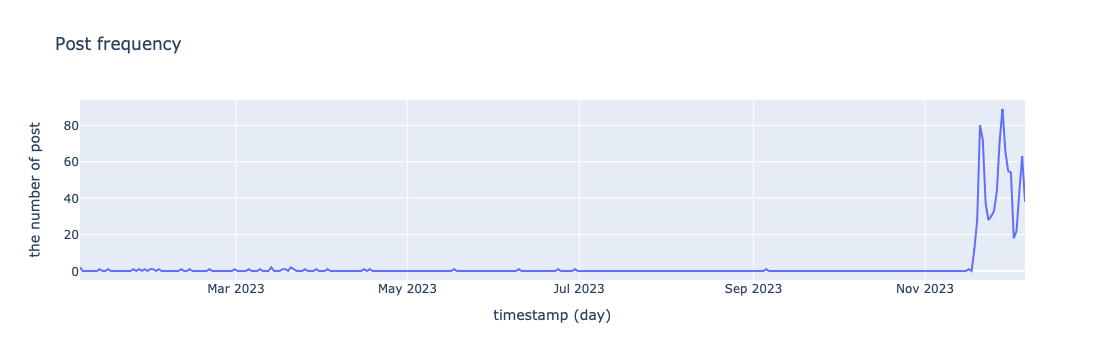

In [40]:
plot_post_freq(df_2023)

# Research Question 1

<b>What are the immediate effects on stock prices of companies mentioned in highly upvoted or viral posts on platforms like WallStreetBets?</b>

To solve this question, we first start with find out the ticker symbol in the context. We have two approachs:<br/>
- <b>Method1:</b> Extract the captialize words in the post.
- <b>Method2:</b> Use openai API to extract the ticker symbol in the context.
<br/>

For both methods, we have to clean up the dataset beforehand.

## Pre-processing

In [5]:
def remove_hyperlink(body):
    body = re.sub(r'https?://\S+|www\.\S+', '', body)
    # body = re.sub(r'/\S/\S+', '', body)
    return body

def remove_punctuation(body):
    punctuation = '!"#%&\()*+,-.:;<=>?@[\\]^_`{|}~'
    body = re.sub(rf'[{punctuation}\\\s]+', " ", body)
    return body

In [6]:
def data_preprocessing(df):
    df["body"].fillna(value = "", inplace = True)
    df["body"] = df["title"] + ": "+ df["body"]
    df["body"] = df["body"].apply(remove_hyperlink)
    df["body"] = df["body"].apply(remove_punctuation)

In [7]:
data_preprocessing(df_kaggle)
# data_preprocessing(df_2023)

## Method1: Extract the capitalize words in the post

In [8]:
stopwords_set = set([i.upper() for i in stopwords.words("english")] + [i for i in stopwords.words("english")])
def remove_stopword(body):
    words = set(body.split(" "))
    words = words - stopwords_set
    return " ".join(words)

def find_potential_ticker_symbol(body):
    return set(re.findall(r'\b[A-Z]+\b', body))

# def propagation_ticker_symbol(df, potential_ticker_symbol):
#     for i in range(df.shape[0]):
#         df["ticker symbol"][i] = df.loc[i, "ticker symbol"] | (set(df.loc[i, "body"].upper().split(" ")) & potential_ticker_symbol)

In [112]:
df_kaggle["ticker symbol"] = df_kaggle["body"]
df_kaggle["ticker symbol"] = df_kaggle["ticker symbol"].apply(remove_stopword)
df_kaggle["ticker symbol"] = df_kaggle["ticker symbol"].apply(find_potential_ticker_symbol)

In [113]:
def find_top_n_ticker_symbol(df, n = 10):
    df["ticker symbol"] = df["body"]
    df["ticker symbol"] = df["ticker symbol"].apply(remove_stopword)
    df["ticker symbol"] = df["ticker symbol"].apply(find_potential_ticker_symbol)
    # find potential ticker symbol
    potential_ticker_symbol_freq = Counter({})
    for i in df["ticker symbol"]:
        potential_ticker_symbol_freq += Counter({k:1 for k in i})
    # find top n ticker symbol
    cnt = 0
    ticker_symbol_top_n = []
    potential_ticker_symbol_sort = [i[0] for i in potential_ticker_symbol_freq.most_common(len(potential_ticker_symbol_freq))]
    for i in potential_ticker_symbol_sort:
        if cnt == n:
            break
        ticker = yf.Ticker(i)
        # _ = ticker.info
        out = ticker.history()
        if out.shape[0]:
            ticker_symbol_top_n.append(i)
            print(f"{i} is a ticker symbol")
            cnt += 1
            
    # propagate ticker symbol
    # company_name = {yf.Ticker(i).info['longName'].split(" ")[0].upper() for i in ticker_symbol_top_n}
    # the mapping of company name and ticker symbol
    # name_ticker_map = {yf.Ticker(i).info['longName'].split(" ")[0].upper():i for i in ticker_symbol_top_n}
    company_name = [yf.Ticker(i).info['longName'].split(" ")[0].upper() for i in ticker_symbol_top_n]
    name_ticker_map = pd.DataFrame([ticker_symbol_top_n], columns = company_name)
    for i in range(df.shape[0]):
        body_set = set(df.loc[i, "body"].upper().split(" "))
        df.at[i, "ticker symbol"] = df.loc[i, "ticker symbol"] | ( (body_set & set(ticker_symbol_top_n) ) | set(name_ticker_map.loc[0, list(body_set & set(company_name))].values))
        
    # If appear in post show "True", if not show "False"
    df.loc[:,ticker_symbol_top_n] = False
    # if appear set True
    for i in range(df.shape[0]):
        df.loc[i, list(df.loc[i, "ticker symbol"] & set(ticker_symbol_top_n))] = True

    return ticker_symbol_top_n

In [114]:
ticker_symbol_top_n_kaggle = find_top_n_ticker_symbol(df_kaggle, 10)
ticker_symbol_top_n_kaggle

I: No data found, symbol may be delisted


GME is a ticker symbol
AMC is a ticker symbol
DD is a ticker symbol


WSB: No price data found, symbol may be delisted (period=1mo)
HOLD: No price data found, symbol may be delisted (period=1mo)
US: No price data found, symbol may be delisted (period=1mo)
BUY: No price data found, symbol may be delisted (period=1mo)


YOLO is a ticker symbol
BB is a ticker symbol


TLDR: No price data found, symbol may be delisted (period=1mo)
SEC: No price data found, symbol may be delisted (period=1mo)


NOK is a ticker symbol
RH is a ticker symbol


CEO: No data found, symbol may be delisted
FUCKING: No data found, symbol may be delisted
P: No price data found, symbol may be delisted (period=1mo)
DR: No price data found, symbol may be delisted (period=1mo)
TL: Period '1mo' is invalid, must be one of ['1d', '5d']


MOON is a ticker symbol


SELL: No data found, symbol may be delisted


PLTR is a ticker symbol
EDIT is a ticker symbol


['GME', 'AMC', 'DD', 'YOLO', 'BB', 'NOK', 'RH', 'MOON', 'PLTR', 'EDIT']

According to the output, we obtain the top 10 ticker symbols: 
1. GME
2. AMC
3. DD
4. YOLO
5. BB
6. NOK
7. RH
8. MOON
9. PLTR
10. EDIT

In [120]:
ticker_symbol_top_n_2023 = find_top_n_ticker_symbol(df_2023, 10)
ticker_symbol_top_n_2023 

['GME', 'AMC', 'DD', 'WSB', 'HOLD', 'YOLO', 'BB', 'US', 'BUY', 'NOK']

## Plot the stock price and the appear frequence of ticker symbol

In [119]:
def plot_stock_and_post_freq(df, target_ticker_symbol):
    # get target ticker symbol post df
    df = df[df[target_ticker_symbol]]
    interval = timedelta(days=1)
    df_freq = get_post_freq(df["timestamp"], interval)
    # get stock price data
    ticker = yf.Ticker(target_ticker_symbol)
    start_date = sorted(df["timestamp"])[0].split(" ")[0]
    start_date = (datetime.strptime(start_date, "%Y-%m-%d") - timedelta(days=20)).strftime("%Y-%m-%d")
    end_date = sorted(df["timestamp"])[-1].split(" ")[0]
    df_stock = ticker.history(start = start_date, end = end_date, interval = "1d")
    # no stock data available
    if len(df_stock) == 0:
        return
    
    fig = go.Figure()
    
    fig.add_trace(go.Scatter(
        x = df_stock.index,
        y = df_stock["Open"],
        name = f"Stock open",
        marker=dict(color="#00CC96")
    ))
    
    
    fig.add_trace(go.Scatter(
        x = df_stock.index,
        y = df_stock["Volume"],
        name = f"Stock volume",
        yaxis="y2",
        marker=dict(color="#636EFA")
    ))
    
    fig.add_trace(go.Bar(
        x=df_freq["timestamp"],
        y=df_freq["frequency"],
        opacity=0.8,
        xperiod=interval.total_seconds()*1000,
        name = "The number of post",
        yaxis="y3",
        marker=dict(color="#FFA15A")
    ))
    
    
    # Create axis objects
    fig.update_layout(
        yaxis=dict(
            title=f"Stock Open",
            titlefont=dict(
                color="#00CC96"
            ),
            tickfont=dict(
                color="#00CC96"
            )
        ),
        yaxis2=dict(
            title=f"Stock Volume",
            titlefont=dict(
                color="#636EFA"
            ),
            tickfont=dict(
                color="#636EFA"
            ),
            anchor="free",
            overlaying="y",
            side="left",
            autoshift=True,
            shift=-50,
        ),
        yaxis3=dict(
            title="The number of post",
            titlefont=dict(
                color="#FFA15A"
            ),
            tickfont=dict(
                color="#FFA15A"
            ),
            anchor="x",
            overlaying="y",
            side="right"
        ),
    )
    
    # Update layout properties
    fig.update_layout(
        title_text=f"Stock Open and Volume and the number of post mentioned <b>{target_ticker_symbol}</b>",
        width=1000,
        height=500,
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        )
    )
    
    fig.show()

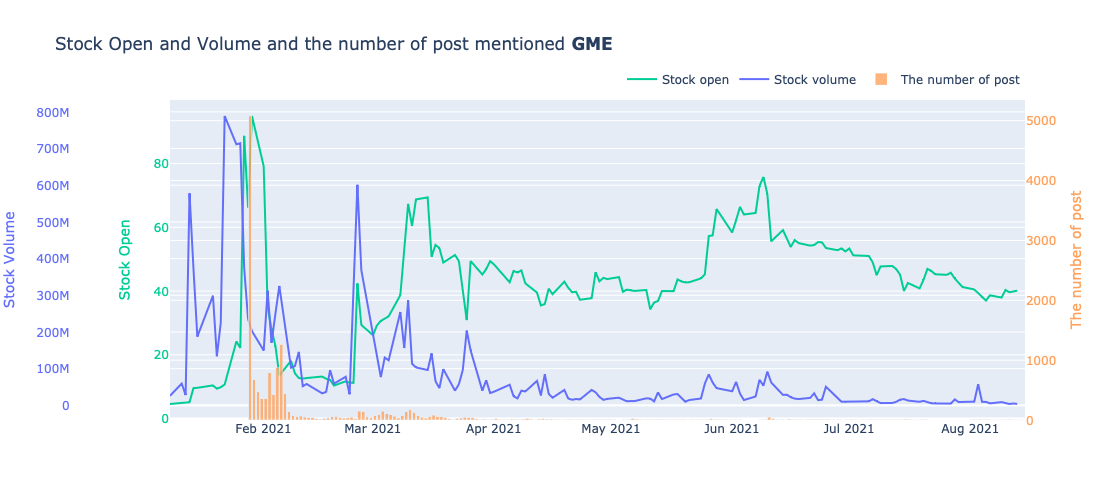

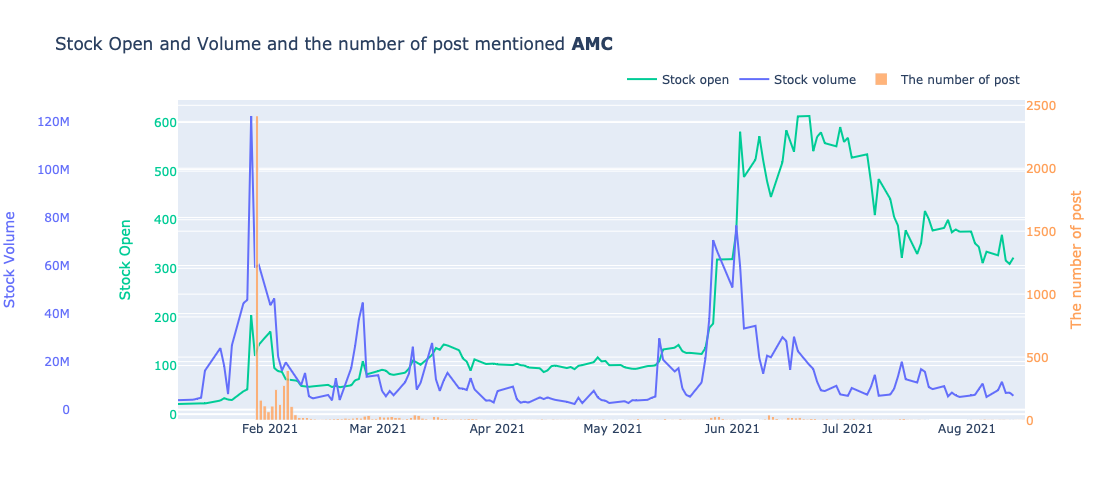

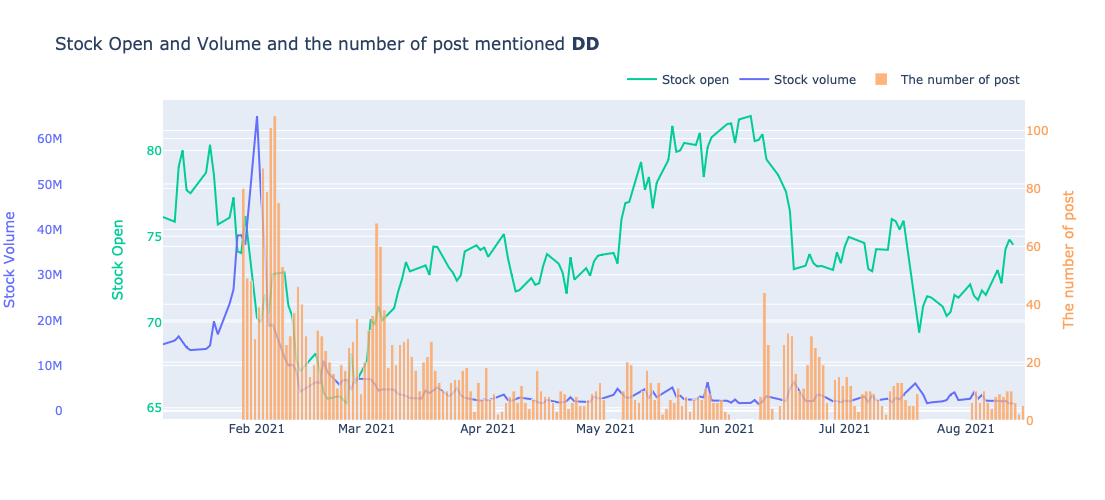

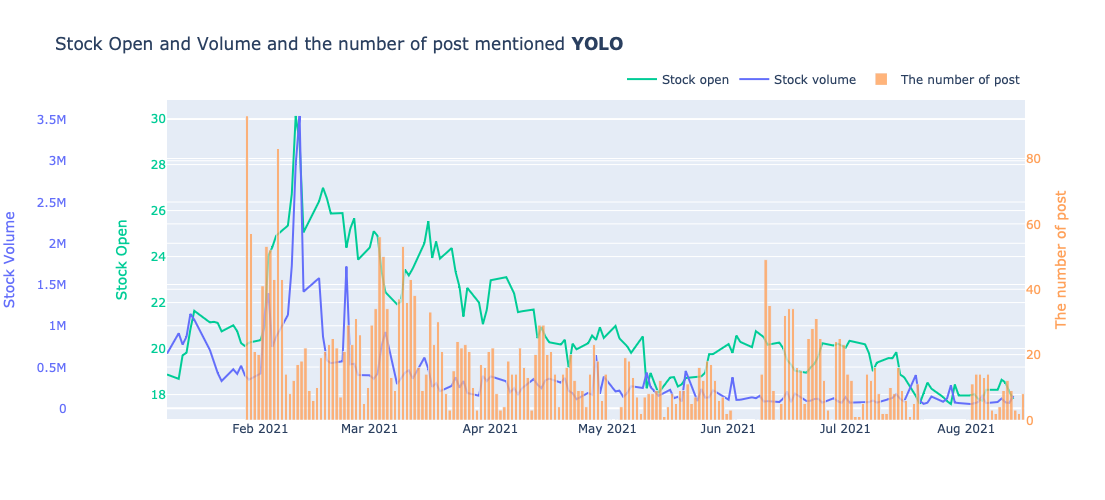

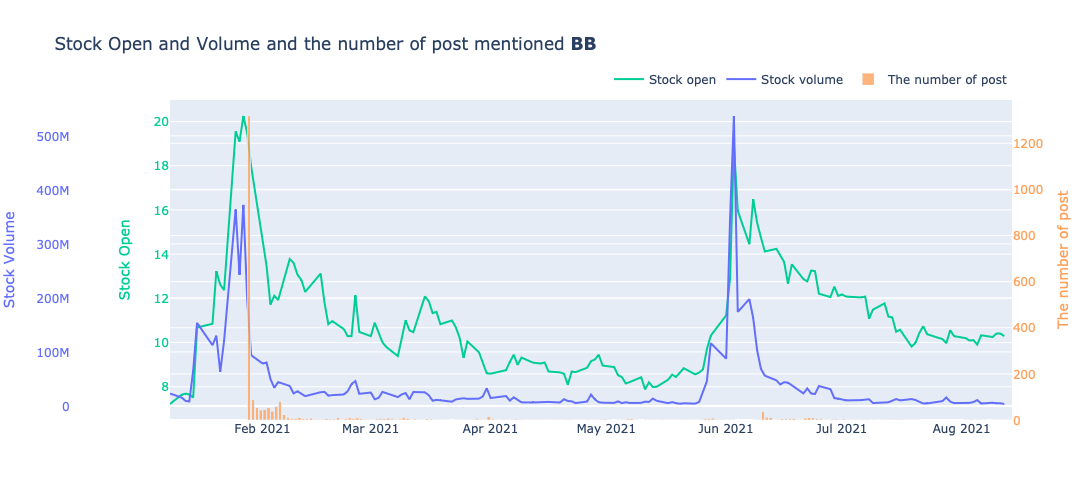

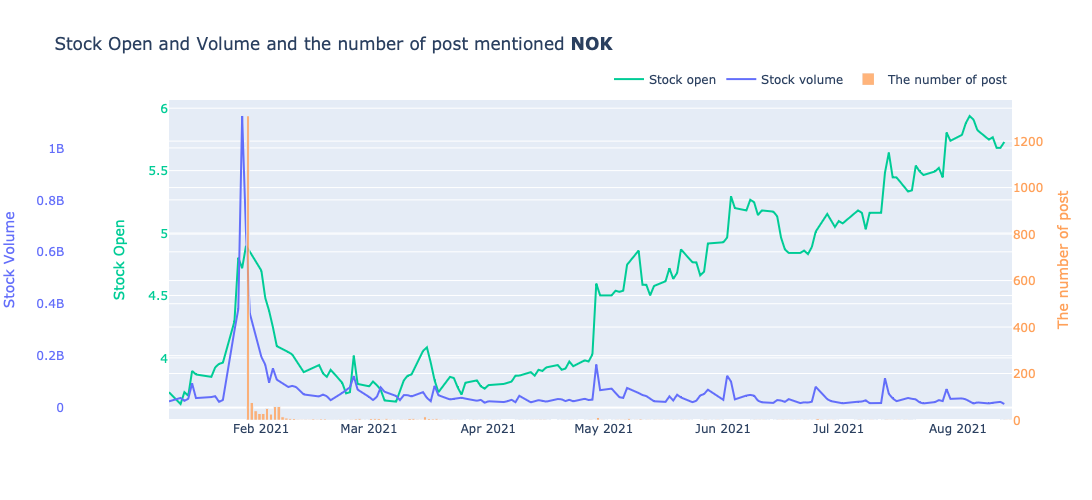

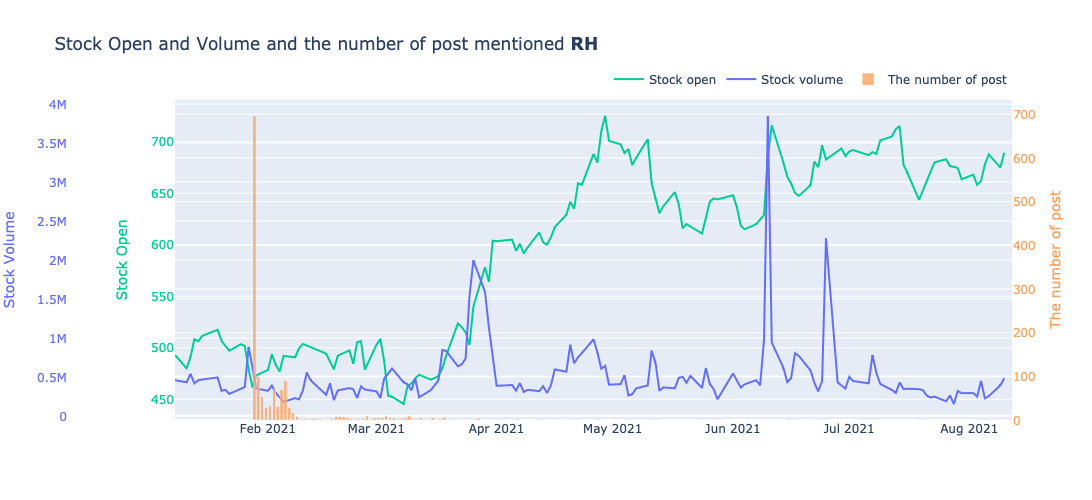

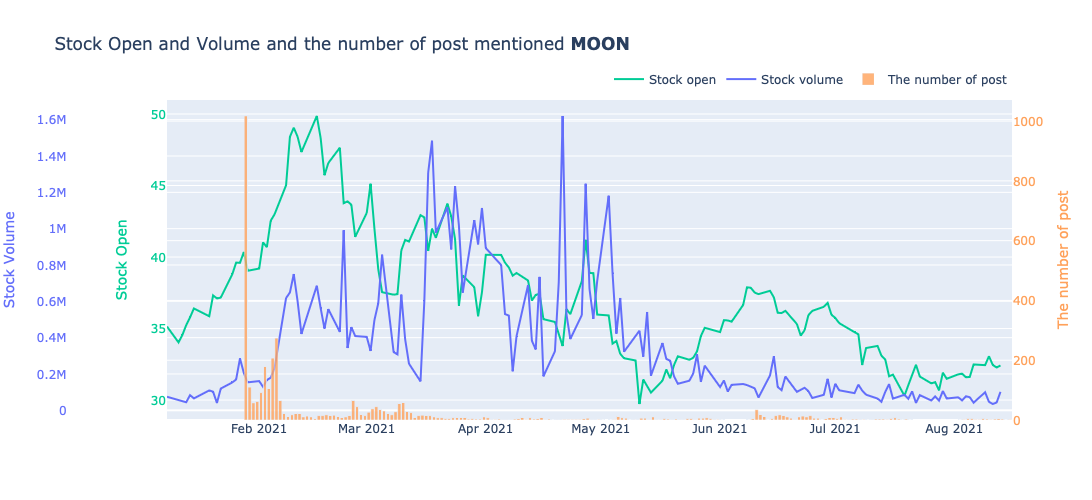

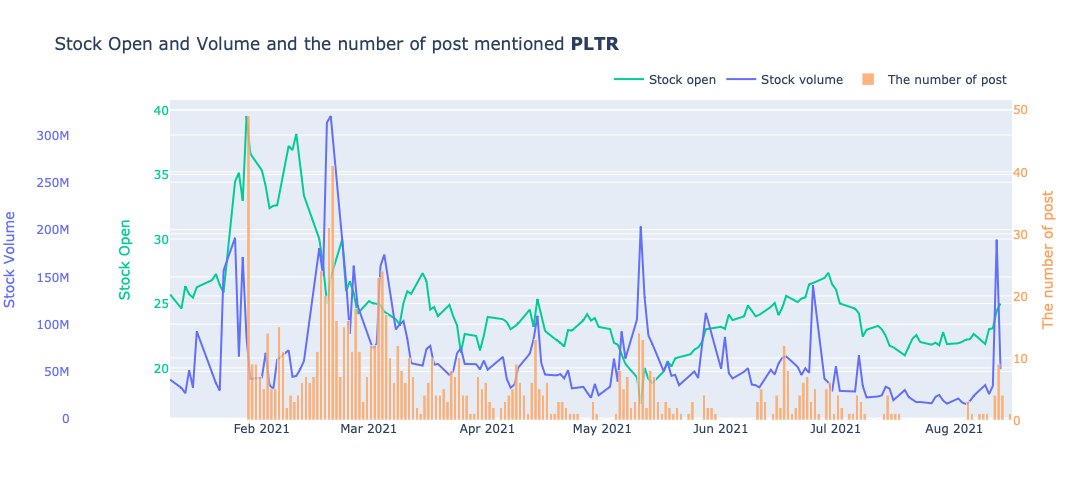

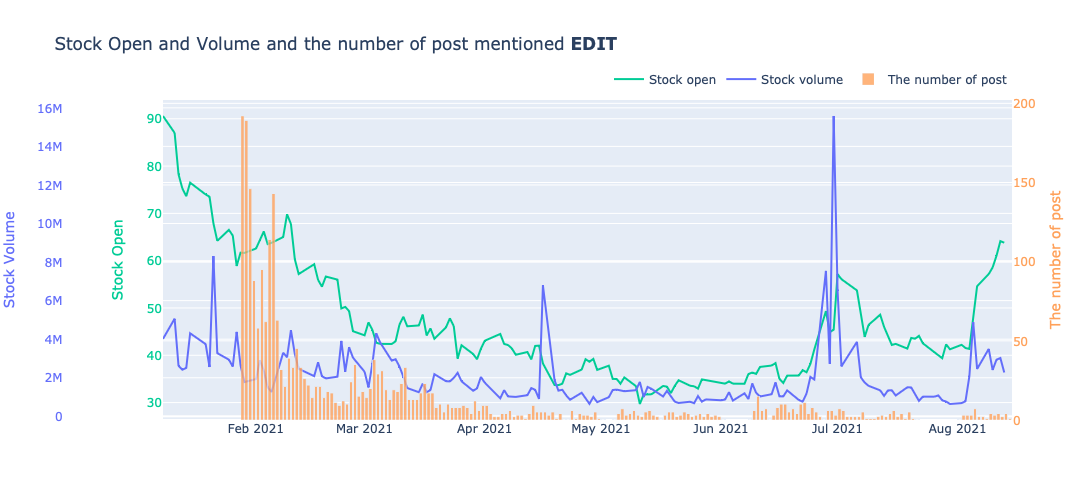

In [120]:
for ticker_symbol in ticker_symbol_top_n_kaggle:
    plot_stock_and_post_freq(df_kaggle, ticker_symbol)

CEO: No timezone found, symbol may be delisted
WSB: No price data found, symbol may be delisted (1d 2023-10-30 -> 2023-12-06)
US: No price data found, symbol may be delisted (1d 2023-02-21 -> 2023-12-06)
P: No price data found, symbol may be delisted (1d 2023-10-30 -> 2023-12-06)


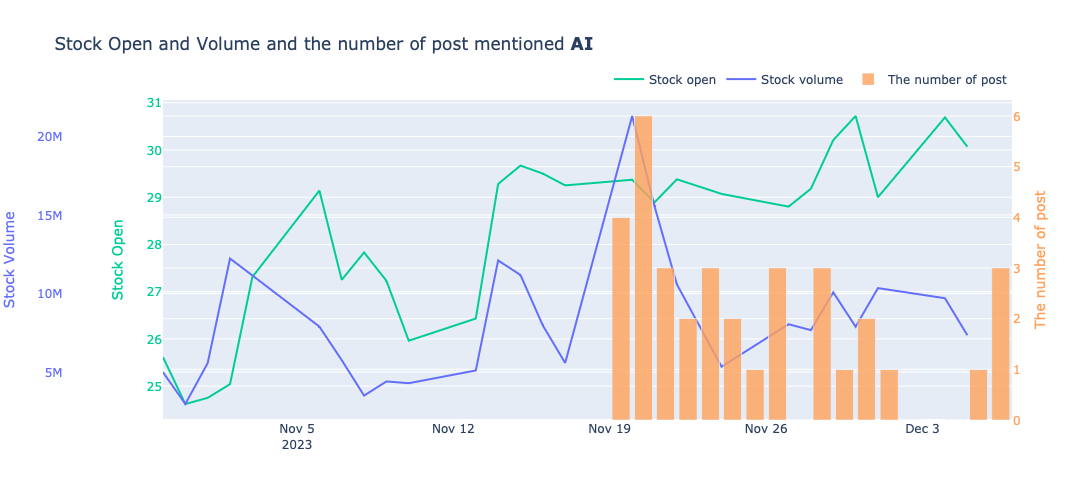

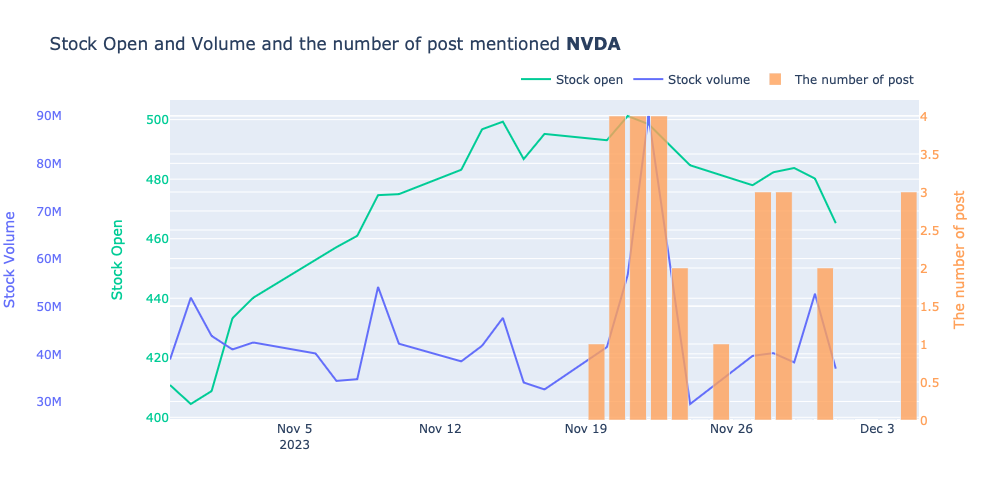

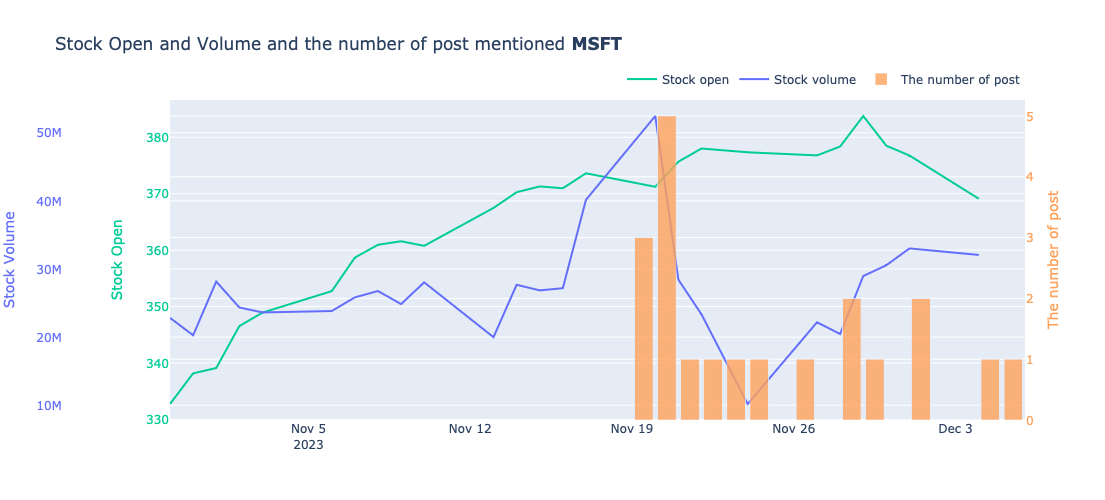

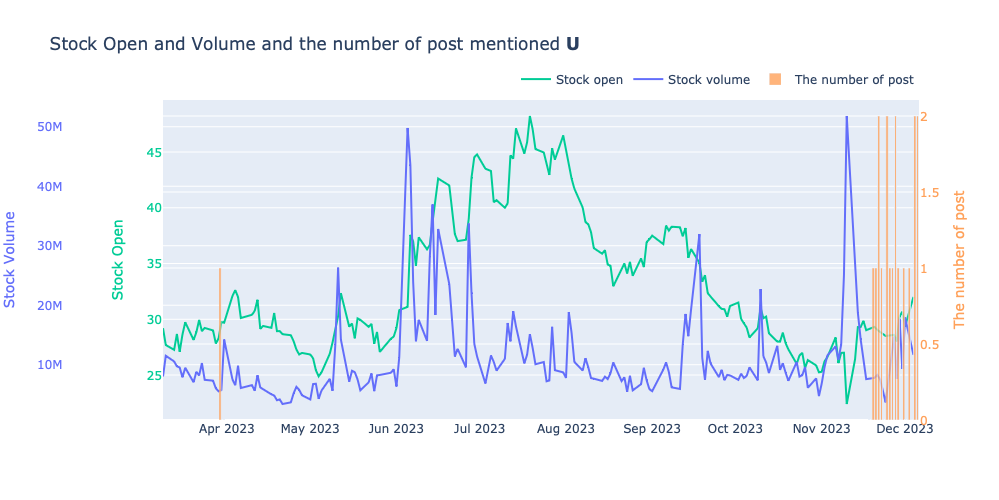

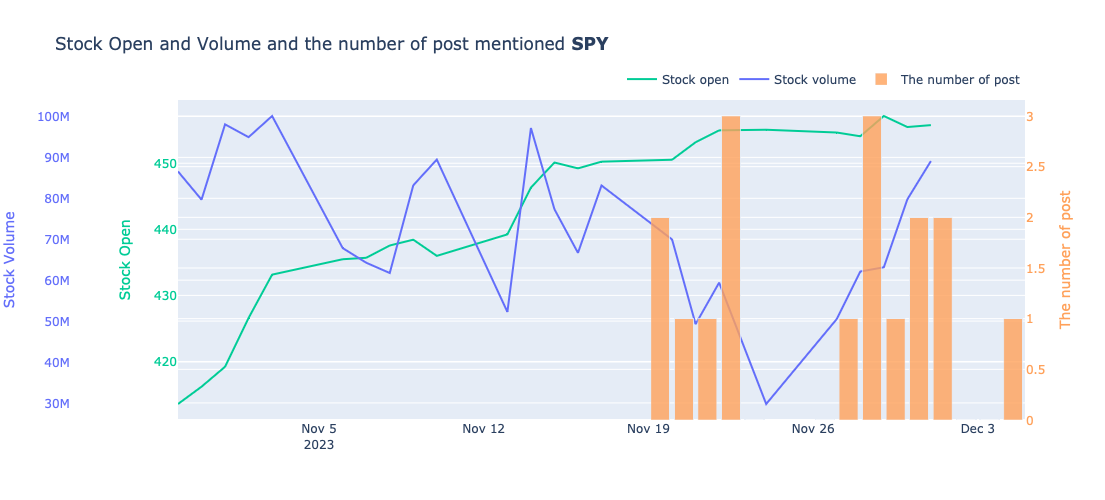

ETF: No price data found, symbol may be delisted (1d 2023-10-30 -> 2023-12-06)


In [306]:
for ticker_symbol in ticker_symbol_top_n_2023:
    plot_stock_and_post_freq(df_2023, ticker_symbol)

## Method2: Use openai API to extract the ticker symbol in the context.

In [19]:
df_kaggle = pd.read_csv("./dataset/reddit_wsb.csv")
df_2023 = pd.read_csv("./dataset/reddit_wsb_2023.csv")

In [20]:
data_preprocessing(df_kaggle)
data_preprocessing(df_2023)

NameError: name 'data_preprocessing' is not defined

In [10]:
df_kaggle = pd.read_csv("./dataset/gpt_analysis_result_top10.csv")

In [11]:
df_kaggle.head(5)

,title,score,id,url,comms_num,created,body,timestamp,response,GME,CLOV,BB,TSLA,WSB,RKT,AMC,SLV,NOK,PLTR
0,"GME Megathread for March 10, 2021",47667,m1xhlc,https://www.reddit.com/r/wallstreetbets/commen...,93268,1.615412e+09,GME Megathread for March 10 2021 HOLYMOLYHOLYM...,2021-03-10 23:30:11,GME:Rise,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"GME Megathread for Wednesday, February 24th, 2021",28975,lre2k6,https://www.reddit.com/r/wallstreetbets/commen...,83094,1.614205e+09,GME Megathread for Wednesday February 24th 202...,2021-02-25 00:24:58,GME:Rise,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,GME What About Second Breakfast Club Megathread,29356,l7v9o8,https://www.reddit.com/r/wallstreetbets/commen...,80586,1.611963e+09,GME What About Second Breakfast Club Megathread,2021-01-30 01:26:04,GME:Rise,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,GME Breakfast Club Megathread,25561,l7s631,https://www.reddit.com/r/wallstreetbets/commen...,77167,1.611955e+09,GME Breakfast Club Megathread,2021-01-29 23:11:27,GME:Rise,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"GME Megathread for March 08, 2021",30653,m0fpgd,https://www.reddit.com/r/wallstreetbets/commen...,77080,1.615239e+09,GME Megathread for March 08 2021 This thread w...,2021-03-08 23:30:21,GME:Rise,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
def plot_stock_and_post_freq(df, target_ticker_symbol):
    # get target ticker symbol post df
    # df_neutral = df[~df[target_ticker_symbol].isna()]
    df_neutral = df[df[target_ticker_symbol] == 0]
    df_positive = df[df[target_ticker_symbol] == 1]
    df_negative = df[df[target_ticker_symbol] == 2]
    interval = timedelta(days=1)
    df_freq_neutral = get_post_freq(df_neutral["timestamp"], interval)
    df_freq_positive = get_post_freq(df_positive["timestamp"], interval)
    df_freq_negative = get_post_freq(df_negative["timestamp"], interval)
    # get stock price data
    ticker = yf.Ticker(target_ticker_symbol)
    start_date = sorted(df["timestamp"])[0].split(" ")[0]
    start_date = (datetime.strptime(start_date, "%Y-%m-%d") - timedelta(days=20)).strftime("%Y-%m-%d")
    end_date = sorted(df["timestamp"])[-1].split(" ")[0]
    df_stock = ticker.history(start = start_date, end = end_date, interval = "1d")
    # df_stock_date_list = pd.date_range(start_date, end_date, freq='1D')
    # no stock data available
    if len(df_stock) == 0:
        return
    
    fig = go.Figure()
    
    fig.add_trace(go.Scatter(
            x = df_stock.index,
            y = df_stock["Open"],
            name = f"Stock open",
            marker=dict(color="#00CC96")
        )
    )
    
    
    fig.add_trace(go.Scatter(
            x = df_stock.index,
            y = df_stock["Volume"],
            name = f"Stock volume",
            yaxis="y2",
            marker=dict(color="#636EFA")
        )
    )
    
    fig.add_trace(go.Bar(
        x=df_freq_neutral["timestamp"],
        y=df_freq_neutral["frequency"],
        xperiod=interval.total_seconds()*1000,
        opacity=0.8,
        name = "The number of neutral post",
        yaxis="y3",
        marker=dict(color="#FFA15A")
    ))
    fig.add_trace(go.Bar(
        x=df_freq_positive["timestamp"],
        y=df_freq_positive["frequency"],
        xperiod=interval.total_seconds()*1000,
        opacity=0.8,
        name = "The number of positive post",
        yaxis="y3",
        marker=dict(color="red")
    ))
    fig.add_trace(go.Bar(
        x=df_freq_negative["timestamp"],
        y=df_freq_negative["frequency"],
        opacity=0.8,
        xperiod=interval.total_seconds()*1000,
        name = "The number of negative post",
        yaxis="y3",
        marker=dict(color="purple")
    ))

    # print(pd.Series(df_stock_date_list))
    # print(df_freq_positive["timestamp"])
    
    
    # Create axis objects
    fig.update_layout(
        yaxis=dict(
            title=f"Stock Open",
            titlefont=dict(
                color="#00CC96"
            ),
            tickfont=dict(
                color="#00CC96"
            )
        ),
        yaxis2=dict(
            title=f"Stock Volume",
            titlefont=dict(
                color="#636EFA"
            ),
            tickfont=dict(
                color="#636EFA"
            ),
            anchor="free",
            overlaying="y",
            side="left",
            autoshift=True,
            shift=-50,
        ),
        yaxis3=dict(
            title="The number of post",
            titlefont=dict(
                color="#FFA15A"
            ),
            tickfont=dict(
                color="#FFA15A"
            ),
            anchor="x",
            overlaying="y",
            side="right",
        ),
    )
    fig.update_layout(barmode='stack')
    # Update layout properties
    fig.update_layout(
        title_text=f"Stock Open and Volume and the number of post mentioned <b>{target_ticker_symbol}</b>",
        width=1000,
        height=500,
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        )
    )
    # fig.update_traces(marker_line_width=0.01)

    fig.show()
    # fig.write_html("test.html")

In [13]:
def plot_stock_and_post_freq(df, target_ticker_symbol):
    # get target ticker symbol post df
    # df_neutral = df[~df[target_ticker_symbol].isna()]
    df_neutral = df[df[target_ticker_symbol] == 0]
    df_positive = df[df[target_ticker_symbol] == 1]
    df_negative = df[df[target_ticker_symbol] == 2]
    interval = timedelta(days=1)
    df_freq_neutral = get_post_freq(df_neutral["timestamp"], interval)
    df_freq_positive = get_post_freq(df_positive["timestamp"], interval)
    df_freq_negative = get_post_freq(df_negative["timestamp"], interval)
    # get stock price data
    ticker = yf.Ticker(target_ticker_symbol)
    start_date = sorted(df["timestamp"])[0].split(" ")[0]
    start_date = (datetime.strptime(start_date, "%Y-%m-%d") - timedelta(days=20)).strftime("%Y-%m-%d")
    end_date = sorted(df["timestamp"])[-1].split(" ")[0]
    df_stock = ticker.history(start = start_date, end = end_date, interval = "1d")
    # df_stock_date_list = pd.date_range(start_date, end_date, freq='1D')
    # no stock data available
    if len(df_stock) == 0:
        return

    fig_list = []
    for i in range(3):
        fig = go.Figure()
        
        fig.add_trace(go.Scatter(
                x = df_stock.index,
                y = df_stock["Open"],
                name = f"Stock open",
                marker=dict(color="#00CC96")
            )
        )
        
        
        fig.add_trace(go.Scatter(
                x = df_stock.index,
                y = df_stock["Volume"],
                name = f"Stock volume",
                yaxis="y2",
                marker=dict(color="#636EFA")
            )
        )
        fig_list.append(fig)

    # color = ["#FFA15A", "red", "purple"]
    color = ["grey", "orange", "purple"]
    fig_list[0].add_trace(go.Bar(
        x=df_freq_neutral["timestamp"],
        y=df_freq_neutral["frequency"],
        xperiod=interval.total_seconds()*1000,
        opacity=0.5,
        name = "The number of neutral post",
        yaxis="y3",
        marker=dict(color=color[0])
    ))
    fig_list[1].add_trace(go.Bar(
        x=df_freq_positive["timestamp"],
        y=df_freq_positive["frequency"],
        xperiod=interval.total_seconds()*1000,
        opacity=0.5,
        name = "The number of positive post",
        yaxis="y3",
        marker=dict(color=color[1])
    ))
    fig_list[2].add_trace(go.Bar(
        x=df_freq_negative["timestamp"],
        y=df_freq_negative["frequency"],
        opacity=0.5,
        xperiod=interval.total_seconds()*1000,
        name = "The number of negative post",
        yaxis="y3",
        marker=dict(color=color[2])
    ))

    # print(pd.Series(df_stock_date_list))
    # print(df_freq_positive["timestamp"])
    
    for i, fig in enumerate(fig_list):
        # Create axis objects
        fig.update_layout(
            yaxis=dict(
                title=f"Stock Open",
                titlefont=dict(
                    color="#00CC96"
                ),
                tickfont=dict(
                    color="#00CC96"
                )
            ),
            yaxis2=dict(
                title=f"Stock Volume",
                titlefont=dict(
                    color="#636EFA"
                ),
                tickfont=dict(
                    color="#636EFA"
                ),
                anchor="free",
                overlaying="y",
                side="left",
                autoshift=True,
                shift=-50,
            ),
            yaxis3=dict(
                title="The number of post",
                titlefont=dict(
                    color=color[i]
                ),
                tickfont=dict(
                    color=color[i]
                ),
                anchor="x",
                overlaying="y",
                side="right",
            ),
        )
        # Update layout properties
        fig.update_layout(
            title_text=f"Stock Open and Volume and the number of post mentioned <b>{target_ticker_symbol}</b>",
            width=1000,
            height=500,
            legend=dict(
                orientation="h",
                yanchor="bottom",
                y=1.02,
                xanchor="right",
                x=1
            )
        )
    
        fig.show()
    # fig.write_html("test.html")

In [18]:
plot_stock_and_post_freq(df_kaggle, "US")

KeyError: 'US'

0     2021-01-08
1     2021-01-09
2     2021-01-10
3     2021-01-11
4     2021-01-12
         ...    
215   2021-08-11
216   2021-08-12
217   2021-08-13
218   2021-08-14
219   2021-08-15
Length: 220, dtype: datetime64[ns]
0     2021-01-28
1     2021-01-29
2     2021-01-30
3     2021-01-31
4     2021-02-01
         ...    
119   2021-08-03
120   2021-08-04
121   2021-08-05
122   2021-08-08
123   2021-08-09
Name: timestamp, Length: 124, dtype: datetime64[ns]


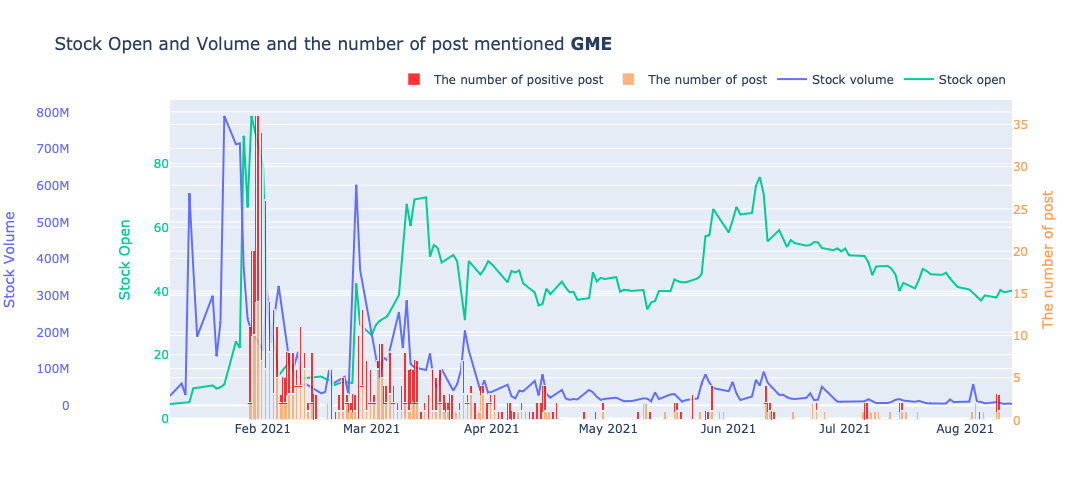

In [93]:
for ticker_symbol in ["GME"]:
    plot_stock_and_post_freq(df_kaggle, ticker_symbol)

# Appendix

This appendix provide some trivial code that we already run it beforehand.